# DSCI 573 - Feature and Model Selection

# Lab 4: A mini project - Putting it all together

## Table of contents
0. [Submission instructions](#si) (4%)
1. [Understanding the problem](#1) (4%)
2. [Data splitting](#2) (2%)
3. [EDA](#3) (10%)
4. (Optional) [Feature engineering](#4)
5. [Preprocessing and transformations](#5) (10%)
6. [Baseline model](#6) (2%)
7. [Linear models](#7) (10%)
8. [Different models](#8) (16%)
9. (Optional) [Feature selection](#9)
10. [Hyperparameter optimization](#10) (10%)
11. [Interpretation and feature importances](#11) (10%)
12. [Results on the test set](#12) (10%)
13. [Summary of the results](#13) (12%)
15. (Optional) [Reproducible data analysis pipeline](#14)
15. (Optional) [Your takeaway from the course](#15)

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:4}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **Which problem did you pick, classification or regression? Classification**
- **Report your test score here along with the metric used: Recall -- 0.721**
- **Please add a link to your GitHub repository here: https://github.ubc.ca/mds-2021-22/DSCI_573_lab4_group_zhshjie_songyjoy**
- **You don't have to but you may work on this assignment in a group (group size <= 4) and submit your assignment as a group.** 
- Below are some instructions on working as a group.  
    - The maximum group size is 4. 
    - You can choose your own group members. Since I don't know your groups in advance, I am not opening this lab as a group lab. So you all will have a separate GitHub repository for your labs and you'll have to decide how you want to collaborate. 
    - Use group work as an opportunity to collaborate and learn new things from each other. 
    - Be respectful to each other and make sure you understand all the concepts in the assignment well. 
    - It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. [Here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members) are some instructions on adding group members in Gradescope.  
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Make at least three commits in your lab's GitHub repository.
- Push the final .ipynb file with your solutions to your GitHub repository for this lab.
- Upload the .ipynb file to Gradescope.
- If the .ipynb file is too big or doesn't render on Gradescope for some reason, also upload a pdf or html in addition to the .ipynb. 
- Make sure that your plots/output are rendered properly in Gradescope.

> [Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.

> As usual, do not push the data to the repository. 

## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler
)
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score,
    auc
)
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
import altair as alt
import shap
from scipy.stats import loguniform, randint

## Introduction <a name="in"></a>

In this lab you will be working on an open-ended mini-project, where you will put all the different things you have learned so far in 571 and 573 together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips
1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 

#### Assessment
We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.


#### A final note
Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Pick your problem and explain what exactly you are trying to predict <a name="1"></a>
<hr>
rubric={reasoning:4}

In this mini project, you will pick one of the following problems: 

- A classification problem of predicting whether a credit card client will default or not. For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

OR 

- A regression problem of predicting `reviews_per_month`, as a proxy for the popularity of the listing with [New York City Airbnb listings from 2019 dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data). Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 
3. Carry out any preliminary preprocessing, if needed (e.g., changing feature names, handling of NaN values etc.)

**Our intuitions and thoughts:**
  1) We can first compare the amount of bill statements and the amount of previous payment, then look at repayment status. Customers have no or less default payment records will be less likely to make default payment for next month. 
  2) Usually the wealthier will get higher amount of given credit, `LIMIT_BAL`, so we assume these customers are less likely to make default payment for next month.
  3) Customers with higher education, lower number in `EDUCATION` (except 0 whose meaning is unknown), are all assumed to be less likely to make default payment for next month.
  4) As shown below, the dataset is imbalanced. We need to add `class_weight = "balanced"` to adjust it.
  5) There is no missing value, so no need to apply imputation.

In [2]:
uci_df = pd.read_csv("UCI_Credit_Card.csv")
uci_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [3]:
uci_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [4]:
uci_df.rename(columns={"default.payment.next.month":"default"}, inplace=True)

In [5]:
uci_df["default"].value_counts()

0    23364
1     6636
Name: default, dtype: int64

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={reasoning:2}

**Your tasks:**

1. Split the data into train and test portions.

> Make decision on the `test_size` based on the capacity of your laptop. Don't forget to use a random state.  

In [6]:
train_df, test_df = train_test_split(uci_df, test_size=0.7, random_state=123)

There are 30,000 datapoints in the dataset. Therefore, to explore ensemble methods which may be computationally intensive, we chose the `test_size` to be 0.7, where `train_size` will be 0.3.

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={viz:4,reasoning:6}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

**1. Summary statistics:**
- There is no missing data here in this dataset, thus no need to impute missing values.
- The target variable `default` has class imbalance, we need to consider this when building the model.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 8388 to 19966
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         9000 non-null   int64  
 1   LIMIT_BAL  9000 non-null   float64
 2   SEX        9000 non-null   int64  
 3   EDUCATION  9000 non-null   int64  
 4   MARRIAGE   9000 non-null   int64  
 5   AGE        9000 non-null   int64  
 6   PAY_0      9000 non-null   int64  
 7   PAY_2      9000 non-null   int64  
 8   PAY_3      9000 non-null   int64  
 9   PAY_4      9000 non-null   int64  
 10  PAY_5      9000 non-null   int64  
 11  PAY_6      9000 non-null   int64  
 12  BILL_AMT1  9000 non-null   float64
 13  BILL_AMT2  9000 non-null   float64
 14  BILL_AMT3  9000 non-null   float64
 15  BILL_AMT4  9000 non-null   float64
 16  BILL_AMT5  9000 non-null   float64
 17  BILL_AMT6  9000 non-null   float64
 18  PAY_AMT1   9000 non-null   float64
 19  PAY_AMT2   9000 non-null   float64
 20  PAY_

In [8]:
train_df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,9000.000000,9000.00000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,...,9000.000000,9000.000000,9000.000000,9000.000000,9.000000e+03,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,15069.999889,166457.52000,1.601556,1.859333,1.551778,35.523111,-0.004778,-0.139778,-0.177222,-0.220556,...,42695.655667,39527.160000,38207.757778,5460.077889,5.684092e+03,5056.576000,4562.583222,4800.025000,4965.094333,0.225667
std,8627.548192,129368.23268,0.489605,0.788003,0.520485,9.214976,1.118334,1.183759,1.188545,1.162590,...,63744.300895,59601.026224,59002.238146,15327.621071,2.093329e+04,15548.844369,12865.348715,15921.896251,15644.760603,0.418044
min,1.000000,10000.00000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-50616.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7596.750000,50000.00000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2192.750000,1651.000000,1099.750000,1000.000000,8.735000e+02,390.000000,269.750000,183.500000,57.500000,0.000000
50%,15156.500000,140000.00000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,18936.500000,18022.500000,16926.000000,2100.000000,2.005000e+03,1780.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,22514.750000,240000.00000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,52422.000000,49103.250000,48445.000000,5007.250000,5.000000e+03,4500.000000,4000.000000,4000.000000,4000.000000,0.000000
max,30000.000000,800000.00000,2.000000,6.000000,3.000000,75.000000,8.000000,7.000000,8.000000,7.000000,...,565669.000000,524315.000000,514975.000000,493358.000000,1.227082e+06,417588.000000,211250.000000,426529.000000,345293.000000,1.000000


In [9]:
train_df["default"].value_counts(normalize=True)

0    0.774333
1    0.225667
Name: default, dtype: float64

<br><br>

**2. Visualization:**
- Correlation matrix    
  According to the correlation matrix, there is high multicolinearity between `BILL_AMT1` to `BILL_AMT6`, `PAY_0` to `PAY_6` and `MARRIAGE` and `AGE`. We can handle this with regularization.
    
- Exploratory data visualizations
    - Second plot    
      There is a clear tendency that those who have credit card default tend to have longer payment delay (higher `PAY_0` value). `PAY_0` may be an important feature in our model.
      
    - Third plot    
      This plot shows the amount of payment VS amount of bill for July, 2005. We can see that for most data in class 1, the amount of bill is higher than the payment.      

In [10]:
cor = train_df.corr()
corr_df = cor.stack().reset_index(name='corr')

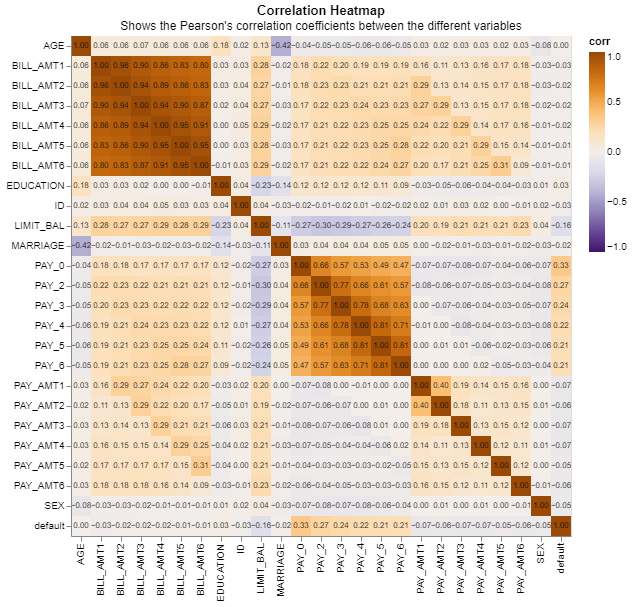

In [11]:
alt.renderers.enable('mimetype')

title = alt.TitleParams(
        text="Correlation Heatmap",
        subtitle="Shows the Pearson's correlation coefficients between the different variables")

plot = alt.Chart(corr_df, title=title).mark_rect().encode(
    x=alt.X('level_0', title=''),
    y=alt.Y('level_1', title=''),
    color=alt.Color('corr', scale=alt.Scale(domain=(-1, 1), scheme='purpleorange'))
)

text = plot.mark_text(
    size=8
).encode(
    text=alt.Text('corr', format=".2f"),
    color=alt.value('black')
)

plot + text

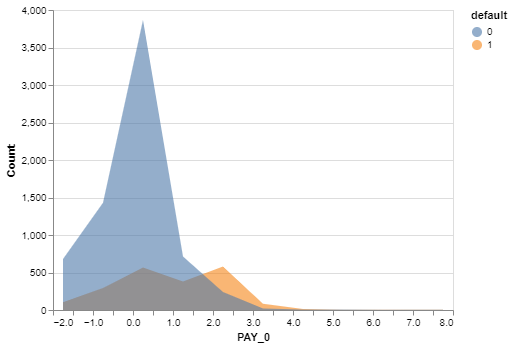

In [12]:
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')
train_df['default'] = train_df['default'].astype("category")
alt.Chart(train_df).mark_area(opacity=0.6).encode(
    x=alt.X('PAY_0', bin=alt.Bin(maxbins=30), title="PAY_0"),
    y=alt.Y('count()', stack=False, title="Count"),
    color=alt.Color('default')
)

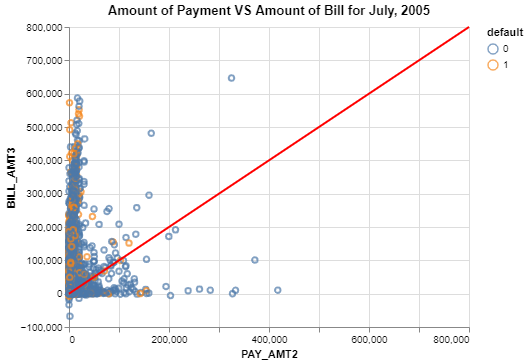

In [13]:
line = pd.DataFrame({
    'x': [0, 800000],
    'y': [0, 800000],
})

line_plot = alt.Chart(line).mark_line(color='red').encode(
    x='x',
    y='y'
)
alt.Chart(
    train_df,
    title="Amount of Payment VS Amount of Bill for July, 2005"
).mark_point().encode(
        alt.X("PAY_AMT3", title="PAY_AMT2"),
        alt.Y("BILL_AMT2", title="BILL_AMT3"),
        color="default"
) + line_plot

**3. Evaluation metrics:**    
Since false negative is more important for us in this question, we choose `recall` and `f1`. Even though many previous literature ([S. Arora, et al. 2021](https://www.sciencedirect.com/science/article/pii/S2214785321035148?via%3Dihub), [S. Neema et al. 2017](https://zenodo.org/record/851527#.Ya_TotCZNPY)) uses accuracy as the evaluation metrics, since [I-Cheng Yeh and Che-hui Lien, 2009](https://www.sciencedirect.com/science/article/pii/S0957417407006719) uses lift chart for the comparison of the models, we use `average_precision` and `roc_auc`, which are similar to lift chart.

In [14]:
scoring_metrics = ["recall", "f1", "average_precision", "roc_auc"]

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [15]:
train_df["EDUCATION"].value_counts()

2    4232
1    3129
3    1504
5      85
4      30
6      14
0       6
Name: EDUCATION, dtype: int64

In [16]:
train_df["PAY_0"].value_counts()

 0    4436
-1    1724
 1    1096
 2     820
-2     782
 3     102
 4      20
 5       9
 8       6
 6       5
Name: PAY_0, dtype: int64

_- We treat `EDUCATION` as a categorical feature instead of an ordinal feature, since there are a lot of values are 0, 5, or 6 which represents unknown. We just keep it as it is for now._

_- We decide to treat `PAY_0` to `PAY_5` as numeric features since the values are just representing the number of months delayed for the payments. According to other documentations, `-2` means no consumption. We will ignore it for now._

In [17]:
drop_features = ["ID"]
binary_features = ["SEX"]
categorical_features = ['EDUCATION', 'MARRIAGE']
target = "default"
numeric_features = list(
    set(train_df.columns)
    - set(drop_features)
    - set(binary_features)
    - set(categorical_features)
    - set([target])
)
assert train_df.columns.shape[0] == len(
    drop_features
    + binary_features
    + categorical_features
    + numeric_features
    + [target]
)

In [18]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary", dtype="int"), binary_features),
    (OneHotEncoder(handle_unknown="ignore", dtype="int"), categorical_features),
    ("drop", drop_features),
)

In [19]:
X_train, y_train = train_df.drop(columns=[target]), train_df[target]
X_test, y_test = test_df.drop(columns=[target]), test_df[target]

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>
rubric={accuracy:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [20]:
results = {}

In [21]:
# Adopted from lecture notes
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [22]:
dummy = DummyClassifier(strategy="stratified")
results['Dummy'] = mean_std_cross_val_scores(
    dummy, X_train, y_train,
    return_train_score=True,
    scoring=scoring_metrics)

pd.DataFrame(results).T

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1,test_average_precision,train_average_precision,test_roc_auc,train_roc_auc
Dummy,0.006 (+/- 0.007),0.018 (+/- 0.009),0.225 (+/- 0.026),0.231 (+/- 0.006),0.224 (+/- 0.023),0.230 (+/- 0.006),0.226 (+/- 0.004),0.226 (+/- 0.001),0.501 (+/- 0.012),0.502 (+/- 0.004)


<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try a linear model as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the regularization hyperparameter. 
3. Report cross-validation scores along with standard deviation. 
4. Summarize your results.

In [23]:
pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=2000))
results['Logistic regression'] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train,
    return_train_score=True,
    scoring=scoring_metrics)

pd.DataFrame(results).T

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1,test_average_precision,train_average_precision,test_roc_auc,train_roc_auc
Dummy,0.006 (+/- 0.007),0.018 (+/- 0.009),0.225 (+/- 0.026),0.231 (+/- 0.006),0.224 (+/- 0.023),0.230 (+/- 0.006),0.226 (+/- 0.004),0.226 (+/- 0.001),0.501 (+/- 0.012),0.502 (+/- 0.004)
Logistic regression,0.217 (+/- 0.026),0.035 (+/- 0.004),0.280 (+/- 0.028),0.278 (+/- 0.016),0.404 (+/- 0.033),0.401 (+/- 0.018),0.522 (+/- 0.039),0.525 (+/- 0.010),0.733 (+/- 0.019),0.738 (+/- 0.004)


In [24]:
param_dist = {
    "logisticregression__C": loguniform(1e-3, 1e3),
    "logisticregression__class_weight": ["balanced", None],
}

In [25]:
random_search = RandomizedSearchCV(
    pipe_lr,
    param_dist,
    n_iter=20,
    verbose=1,
    n_jobs=-1,
    scoring=scoring_metrics,
    refit="recall"
)
random_search.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [26]:
random_search.best_params_

{'logisticregression__C': 6.27177595867164,
 'logisticregression__class_weight': 'balanced'}

In [27]:
pipe_best_lr = random_search.best_estimator_

In [28]:
results['Logistic regression_tuned'] = mean_std_cross_val_scores(
    pipe_best_lr, X_train, y_train,
    return_train_score=True,
    scoring=scoring_metrics)

pd.DataFrame(results).T

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1,test_average_precision,train_average_precision,test_roc_auc,train_roc_auc
Dummy,0.006 (+/- 0.007),0.018 (+/- 0.009),0.225 (+/- 0.026),0.231 (+/- 0.006),0.224 (+/- 0.023),0.230 (+/- 0.006),0.226 (+/- 0.004),0.226 (+/- 0.001),0.501 (+/- 0.012),0.502 (+/- 0.004)
Logistic regression,0.217 (+/- 0.026),0.035 (+/- 0.004),0.280 (+/- 0.028),0.278 (+/- 0.016),0.404 (+/- 0.033),0.401 (+/- 0.018),0.522 (+/- 0.039),0.525 (+/- 0.010),0.733 (+/- 0.019),0.738 (+/- 0.004)
Logistic regression_tuned,0.307 (+/- 0.045),0.031 (+/- 0.000),0.663 (+/- 0.033),0.669 (+/- 0.005),0.484 (+/- 0.016),0.491 (+/- 0.006),0.519 (+/- 0.041),0.522 (+/- 0.010),0.734 (+/- 0.019),0.739 (+/- 0.004)


- For this dataset, we want to minimize False Negatives. Therefore, we prefer models with higher recall scores.
- The default logistic regression seems underfit. The train and test recalls are both very low, and even the test score is a bit higher. 
- The tuned logistic regression performs much better than the default one for recall scores. F1 score gets higher as well, but theres no much difference in other scores.

<br><br>

## 8. Different models <a name="8"></a>
<hr>
rubric={accuracy:10,reasoning:6}

**Your tasks:**
1. Try at least 3 other models aside from a linear model. 
2. Summarize your results in terms of overfitting/underfitting and fit and score times. Can you beat a linear model? 

In [29]:
pipe_knn = make_pipeline(preprocessor, KNeighborsClassifier())
pipe_nb = make_pipeline(preprocessor, BernoulliNB())
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))
pipe_xgb = make_pipeline(
    preprocessor,
    XGBClassifier(
        eval_metric="logloss",
        verbosity=0,
        use_label_encoder=False,
        random_state=123
    )
)


models = {
    "KNN": pipe_knn,
    "Naive Bayes": pipe_nb,
    "Random forest": pipe_rf,
    "LightGBM": pipe_lgbm,
    "XGBoost": pipe_xgb
}

In [30]:
np.random.seed(123)
for name, model in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train,
        return_train_score=True,
        scoring=scoring_metrics
    )

pd.DataFrame(results).T

,fit_time,score_time,test_recall,train_recall,test_f1,train_f1,test_average_precision,train_average_precision,test_roc_auc,train_roc_auc
Dummy,0.006 (+/- 0.007),0.018 (+/- 0.009),0.225 (+/- 0.026),0.231 (+/- 0.006),0.224 (+/- 0.023),0.230 (+/- 0.006),0.226 (+/- 0.004),0.226 (+/- 0.001),0.501 (+/- 0.012),0.502 (+/- 0.004)
Logistic regression,0.217 (+/- 0.026),0.035 (+/- 0.004),0.280 (+/- 0.028),0.278 (+/- 0.016),0.404 (+/- 0.033),0.401 (+/- 0.018),0.522 (+/- 0.039),0.525 (+/- 0.010),0.733 (+/- 0.019),0.738 (+/- 0.004)
Logistic regression_tuned,0.307 (+/- 0.045),0.031 (+/- 0.000),0.663 (+/- 0.033),0.669 (+/- 0.005),0.484 (+/- 0.016),0.491 (+/- 0.006),0.519 (+/- 0.041),0.522 (+/- 0.010),0.734 (+/- 0.019),0.739 (+/- 0.004)
KNN,0.026 (+/- 0.008),0.898 (+/- 0.248),0.365 (+/- 0.010),0.470 (+/- 0.006),0.444 (+/- 0.013),0.572 (+/- 0.006),0.426 (+/- 0.012),0.647 (+/- 0.006),0.705 (+/- 0.005),0.882 (+/- 0.003)
Naive Bayes,0.034 (+/- 0.005),0.022 (+/- 0.004),0.458 (+/- 0.030),0.461 (+/- 0.019),0.394 (+/- 0.033),0.397 (+/- 0.037),0.346 (+/- 0.057),0.349 (+/- 0.063),0.650 (+/- 0.031),0.653 (+/- 0.032)
Random forest,2.486 (+/- 0.248),0.158 (+/- 0.019),0.378 (+/- 0.013),0.998 (+/- 0.001),0.476 (+/- 0.012),0.999 (+/- 0.000),0.542 (+/- 0.011),1.000 (+/- 0.000),0.762 (+/- 0.005),1.000 (+/- 0.000)
LightGBM,0.252 (+/- 0.042),0.039 (+/- 0.005),0.381 (+/- 0.010),0.576 (+/- 0.007),0.484 (+/- 0.015),0.708 (+/- 0.005),0.552 (+/- 0.020),0.888 (+/- 0.004),0.770 (+/- 0.013),0.958 (+/- 0.002)
XGBoost,1.117 (+/- 0.040),0.043 (+/- 0.004),0.375 (+/- 0.018),0.790 (+/- 0.016),0.472 (+/- 0.015),0.876 (+/- 0.011),0.520 (+/- 0.009),0.980 (+/- 0.005),0.753 (+/- 0.004),0.993 (+/- 0.002)


- According to the results above, we can see that RandomForest overfits the most. Train scores for all scoring metrics equal or nearly equal to 1, while the test scores are much lower.
- XGBoost also overfits. The test recall is about half of the train recall.
- Considering the recall score, the tuned logistic regression still performs the best.

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV`, forward selection or L1 regularization for this. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. In at least one case you should be optimizing multiple hyperparameters for a single model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize) 

In [31]:
param_dist_dict = {
    "KNN": {
        "kneighborsclassifier__n_neighbors": np.arange(1, 50, 5),
    },
    "Naive Bayes": {
        "bernoullinb__alpha": loguniform(1e-3, 1e4)
    },
#     "Random forest": {
#         "randomforestclassifier__n_estimators": np.arange(1, 800, 100),
#         "randomforestclassifier__max_depth": np.arange(1, 100, 10),
#         "randomforestclassifier__max_features": np.arange(1, 30, 5),
#         "randomforestclassifier__class_weight": ["balanced", None],
#     },
    "LightGBM": {
        "lgbmclassifier__n_estimators":  np.arange(1, 1000, 100),
        "lgbmclassifier__max_depth":  np.arange(1, 100, 10),
        "lgbmclassifier__learning_rate": loguniform(1, 1e5),
        "lgbmclassifier__class_weight": ["balanced", None],
    },
    "XGBoost": {
        "xgbclassifier__n_estimators":  np.arange(1, 1000, 100),
        "xgbclassifier__max_depth":  np.arange(1, 100, 10),
        "xgbclassifier__learning_rate": loguniform(1, 1e5),
        "xgbclassifier__class_weight": ["balanced", None],
    }
}

In [32]:
np.random.seed(123)

pipe_best = {}

for name, param_dist in param_dist_dict.items():
    random_search = RandomizedSearchCV(
        models[name],
        param_distributions=param_dist,
        n_iter=10,
        verbose=1,
        n_jobs=-1,
        scoring=scoring_metrics,
        refit="recall"
    )
    random_search.fit(X_train, y_train)
    pipe_best[name] = random_search.best_estimator_
    results[name + '_tuned'] = mean_std_cross_val_scores(
        pipe_best[name], X_train, y_train,
        return_train_score=True,
        scoring=scoring_metrics
    )

pd.DataFrame(results).T

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


,fit_time,score_time,test_recall,train_recall,test_f1,train_f1,test_average_precision,train_average_precision,test_roc_auc,train_roc_auc
Dummy,0.006 (+/- 0.007),0.018 (+/- 0.009),0.225 (+/- 0.026),0.231 (+/- 0.006),0.224 (+/- 0.023),0.230 (+/- 0.006),0.226 (+/- 0.004),0.226 (+/- 0.001),0.501 (+/- 0.012),0.502 (+/- 0.004)
Logistic regression,0.217 (+/- 0.026),0.035 (+/- 0.004),0.280 (+/- 0.028),0.278 (+/- 0.016),0.404 (+/- 0.033),0.401 (+/- 0.018),0.522 (+/- 0.039),0.525 (+/- 0.010),0.733 (+/- 0.019),0.738 (+/- 0.004)
Logistic regression_tuned,0.307 (+/- 0.045),0.031 (+/- 0.000),0.663 (+/- 0.033),0.669 (+/- 0.005),0.484 (+/- 0.016),0.491 (+/- 0.006),0.519 (+/- 0.041),0.522 (+/- 0.010),0.734 (+/- 0.019),0.739 (+/- 0.004)
KNN,0.026 (+/- 0.008),0.898 (+/- 0.248),0.365 (+/- 0.010),0.470 (+/- 0.006),0.444 (+/- 0.013),0.572 (+/- 0.006),0.426 (+/- 0.012),0.647 (+/- 0.006),0.705 (+/- 0.005),0.882 (+/- 0.003)
Naive Bayes,0.034 (+/- 0.005),0.022 (+/- 0.004),0.458 (+/- 0.030),0.461 (+/- 0.019),0.394 (+/- 0.033),0.397 (+/- 0.037),0.346 (+/- 0.057),0.349 (+/- 0.063),0.650 (+/- 0.031),0.653 (+/- 0.032)
Random forest,2.486 (+/- 0.248),0.158 (+/- 0.019),0.378 (+/- 0.013),0.998 (+/- 0.001),0.476 (+/- 0.012),0.999 (+/- 0.000),0.542 (+/- 0.011),1.000 (+/- 0.000),0.762 (+/- 0.005),1.000 (+/- 0.000)
LightGBM,0.252 (+/- 0.042),0.039 (+/- 0.005),0.381 (+/- 0.010),0.576 (+/- 0.007),0.484 (+/- 0.015),0.708 (+/- 0.005),0.552 (+/- 0.020),0.888 (+/- 0.004),0.770 (+/- 0.013),0.958 (+/- 0.002)
XGBoost,1.117 (+/- 0.040),0.043 (+/- 0.004),0.375 (+/- 0.018),0.790 (+/- 0.016),0.472 (+/- 0.015),0.876 (+/- 0.011),0.520 (+/- 0.009),0.980 (+/- 0.005),0.753 (+/- 0.004),0.993 (+/- 0.002)
KNN_tuned,0.027 (+/- 0.012),0.477 (+/- 0.065),0.402 (+/- 0.011),0.999 (+/- 0.001),0.402 (+/- 0.010),0.999 (+/- 0.000),0.296 (+/- 0.007),0.998 (+/- 0.001),0.613 (+/- 0.007),0.999 (+/- 0.000)
Naive Bayes_tuned,0.034 (+/- 0.006),0.034 (+/- 0.004),0.458 (+/- 0.028),0.463 (+/- 0.020),0.394 (+/- 0.032),0.397 (+/- 0.038),0.347 (+/- 0.056),0.349 (+/- 0.063),0.650 (+/- 0.031),0.653 (+/- 0.032)


- The tuned LightGBM is the best model, although the recall is a bit lower than logistic regression, but it has the highest f1 score.
- The tuned XGBoost no longer overfits.
- Comparing the recall scores, the tuned logistic regression is the second best model.
- We decided to drop RandomForest. The tuned model was still overfitting while it took the longest time to run. 

<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`), or any other methods of your choice, to examine the most important features of one of the non-linear models. 
2. Summarize your observations. 

In [33]:
preprocessor.fit(X_train, y_train);

In [34]:
feature_names = (
    numeric_features
    + list(
        pipe_best['LightGBM'].named_steps["columntransformer"]
        .named_transformers_["onehotencoder-1"]
        .get_feature_names_out()
    )
    + list(
        pipe_best['LightGBM'].named_steps["columntransformer"]
        .named_transformers_["onehotencoder-2"]
        .get_feature_names_out()
    )
)

In [35]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index
)
X_train_enc.head()

,BILL_AMT3,BILL_AMT4,PAY_AMT2,PAY_AMT4,LIMIT_BAL,PAY_5,PAY_AMT1,AGE,BILL_AMT5,PAY_2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
8388,-0.675935,-0.658066,-0.253634,-0.354661,0.104687,0.231568,-0.331778,-0.599396,-0.656941,-0.726728,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11746,0.472927,-0.622767,1.645552,-0.354661,0.104687,-0.646323,-0.160509,-0.273821,-0.663233,0.118086,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14284,-0.542327,-0.569803,-0.128181,-0.121308,-1.209464,0.231568,-0.280625,1.245530,-0.553665,0.118086,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21820,-0.554209,-0.489540,-0.128228,-0.121463,-1.054858,0.231568,-0.225754,-0.924971,-0.423542,0.118086,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22146,-0.670457,-0.643053,-0.235862,-0.288588,1.496142,-0.646323,-0.270969,-0.707921,-0.649944,-1.571541,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [36]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index
)
X_test_enc.head()

,BILL_AMT3,BILL_AMT4,PAY_AMT2,PAY_AMT4,LIMIT_BAL,PAY_5,PAY_AMT1,AGE,BILL_AMT5,PAY_2,...,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
25665,-0.481206,-0.669833,-0.223775,1.384448,-0.977555,-0.646323,-0.271426,-1.033496,0.075453,0.118086,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16464,0.101419,0.128322,-0.170938,-0.230056,-0.668343,0.231568,-0.146677,2.547830,0.181967,0.118086,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22386,1.696323,1.802322,0.038979,0.655861,0.027384,1.987352,0.087424,-0.599396,2.157244,1.807714,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10149,-0.681456,-0.669833,-0.271549,-0.354661,0.259294,-1.524215,-0.307833,0.594380,-0.663233,-1.571541,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8729,-0.548290,-0.525106,-0.216609,-0.328154,-0.900252,0.231568,-0.281865,0.811430,-0.505223,0.118086,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [37]:
pipe_best['LightGBM'].fit(X_train, y_train);

In [38]:
lgbm_explainer = shap.TreeExplainer(pipe_best['LightGBM'].named_steps["lgbmclassifier"])
train_lgbm_shap_values = lgbm_explainer.shap_values(X_train_enc)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [39]:
test_lgbm_shap_values = lgbm_explainer.shap_values(X_test_enc[:100])

In [40]:
shap.initjs()

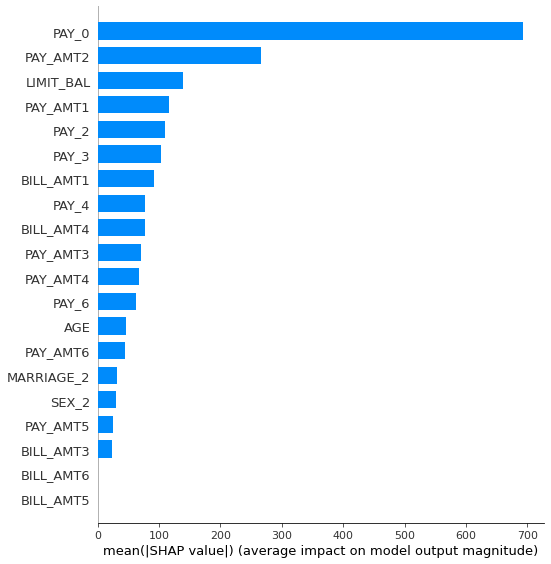

In [41]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc, plot_type="bar")

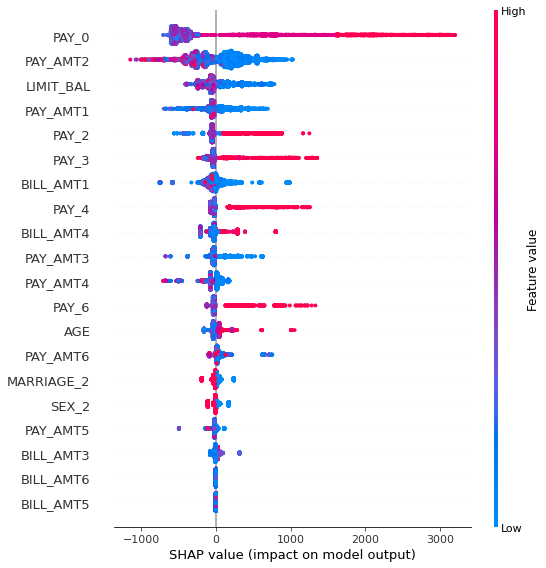

In [42]:
shap.summary_plot(train_lgbm_shap_values[1], X_train_enc)

The selected model is the tuned LightGBM.
- The features are ranked in descending order of feature importances. The second plot also shows the direction of how the features are going to drive the prediction.
- From the plots above, we can see that `PAY_0` is the most important feature. The higher value of `PAY_0` seems to have higher SHAP value for class1.

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={accuracy:6,reasoning:4}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 
3. Take one or two test predictions and explain them with SHAP force plots.  

In [43]:
pipe_best['LightGBM'].score(X_test, y_test)

0.7206666666666667

**Test score**    
The test score is 0.721. It is a fair score. However, it is higher than the validation score, 0.636. We cannot trust the result. Since we do have the issue with optimization bias. Our `train_size` is 0.3, and we did several cross-validation which hit the validation set many times.

In [44]:
X_train_enc = X_train_enc.round(3)
X_test_enc = X_test_enc.round(3)

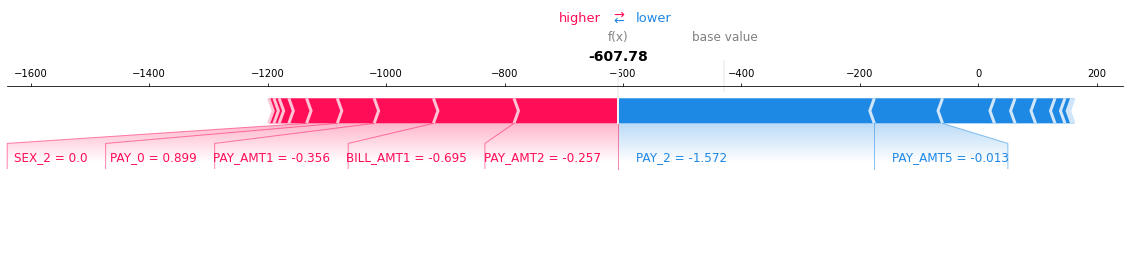

In [45]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][8],
    X_test_enc.iloc[8, :],
    matplotlib=True,
)

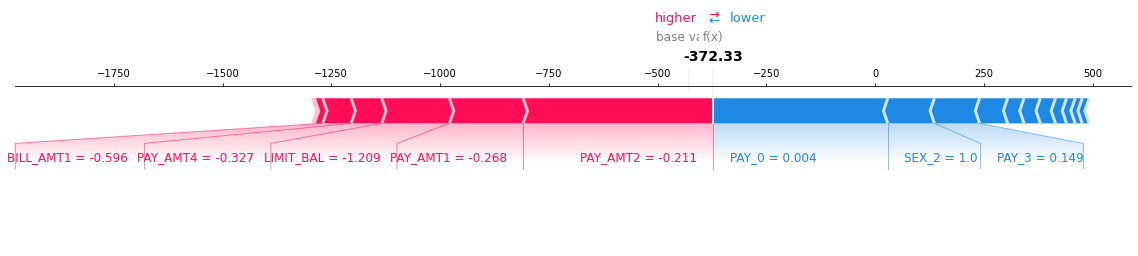

In [46]:
shap.force_plot(
    lgbm_explainer.expected_value[1],
    test_lgbm_shap_values[1][12],
    X_test_enc.iloc[12, :],
    matplotlib=True,
)

In [47]:
lgbm_explainer.expected_value

[428.7946051163243, -428.7946051163243]

**Test predictions**
- Everything is with respect to class 1, default payment for next month.
- The plots above show the forces that drive the prediction. The red features are the ones push the prediction to a higher value, and the blue ones are pushing the prediction to a lower value.

- In this case, the base value for class 1, default payment, is -428.8.

- For the **first example**, the raw model score is -607.78 < base value. It is predicted as class 0, no default payment for next month. Some of the forces driving the prediction towards higher value are:
    - `PAY_0` = 0.899
    - `BILL_AMT1` = -0.695
    
- For the **second example**, the raw model score is -372.33 > base value. It is then predicted as class 1, default payment for next month. Some of the forces driving the prediction towards lower value are:
    - `PAY_0` = 0.004,
    - `PAY_3` = 0.149

<br><br>

## 13. Summary of results <a name="13"></a>
<hr>
rubric={reasoning:12}

Imagine that you want to present the summary of these results to your boss and co-workers. 

**Your tasks:**

1. Create a table summarizing important results. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 
3. Report your final test score along with the metric you used at the top of this notebook in the [Submission instructions section](#si).

**1. Summary of important results**    

Model |Validation Recall Score | Training Recall Score | Validation f1 Score | Training f1 Score |
-----------|      ------------|------------|---------|------|
Logistic regression (tuned)  |  0.663   | 0.669   | 0.484 | 0.491 |
KNN (tuned)   |  0.402 |  0.999  | 0.402 | 0.999 |
Naive Bayes (tuned)  | 0.458    | 0.463  | 0.394 | 0.397 |
LightGBM (tuned)  | 0.636 |  0.693  | 0.510  | 0.554 |
XGBoost (tuned)   | 0.520  |  0.527  | 0.427  |  0.438  |

**2. Conclusion:**
- In this study, we compares six major classification models in supervised machine learning that may be useful for credit card default. Since we want to detect as many "real" default cases as possible, we choose to optimize recall score when we do hyperparameter optimization and model comparison.
- After hyperparameter optimization, logistic regression has the highest validation recall score (0.663) while LightGBM has the second highest validation recall score (0.636) and the highest validation f1 score (0.510). In our study, given that LightGBM performs better in both recall and f1 score, we believe `LightGBM` is the optimal model for credit card default classification.
- An explanation about why LightGBM doesn't have the highest validation recall score is that we set all the random state into 123. In our experiments, we actually got results where LightGBM has both the highest recall score and the highest f1 score.

**3. Other ideas:**
- About feature engineering:
    - Difference between `BILL_AMT`s and `PAY_AMT`s may be a good feature. We can add this feature and see if the performance can improve.
    - There are many time-series features in this data set. For example, `PAY_0` to `PAY_6`, `BILL_AMT1` to `BILL_AMT6` and `PAY_AMT1` to `PAY_AMT6`. We may consider this time-series effect when we do feature engineering.
    
- About train-test-split:
    - We can try different ratio of the test data.

<br><br>

## (Optional) 14. Creating a data analysis pipeline <a name="14"></a>
rubric={reasoning:2}

**Your tasks:**
- In 522 you learned how build a reproducible data analysis pipeline. Convert this notebook into scripts and create a reproducible data analysis pipeline with appropriate documentation. 

<br><br>

## (Optional) 15. Your takeaway from the course <a name="15"></a>
<hr>
rubric={reasoning:1}

**Your tasks:**

What is your biggest takeaway from this course? 

1. Never break the golden rule. Do the train-test split right away.
2. Always use baselines as references.

<br><br>

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. If the .ipynb file is too big and doesn't render on Gradescope, also upload a pdf or html in addition to the .ipynb so that the TAs can view your submission on Gradescope. 

Well done!! Have a great weekend! 

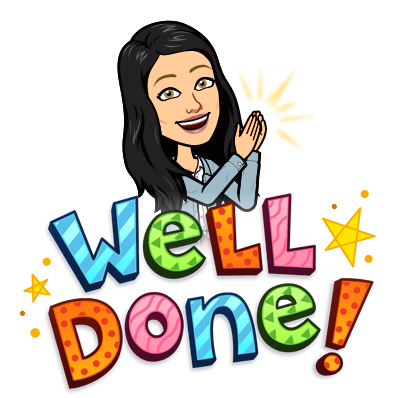

In [48]:
from IPython.display import Image

Image("eva-well-done.png")